# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [25]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [26]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [27]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 9911 / 11441 MB available


In [28]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel(float* c, float* a, float* b, int cols) {
    unsigned int i=blockIdx.x*blockDim.x+threadIdx.x;
    unsigned int j=blockIdx.y*blockDim.y+threadIdx.y;
    
    //Pseudocode
    //c[j][i]=a[j][a]+b[j][i]
    unsigned int k=j*cols+i;
    
    c[k]=a[k]+b[k];
}

//Note

__global__ void matrixVectorKernel(float* c, float* A, float* b, int A_rows, int A_cols) {
//Write for loop that computes the vector-vector inner product
//of row j of A by our vector b and store results in c[j]
// i index is always equal to 0

    unsigned int j=blockIdx.y*blockDim.y + threadIdx.y;

    float sum=0.0f;
    
    for (int i=0; i<A_cols; ++i) {
        unsigned int k=j*A_cols+i;
        sum +=A[k]*b[i];
    }
    
    c[j]=sum;
}

"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("matrixVectorKernel");

/usr/lib/python3/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


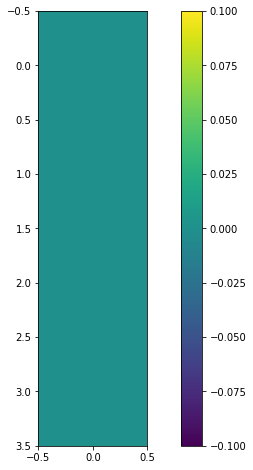

In [16]:
#Size of our test
A_size = (4,3)
b_size = (3,1)
c_size = (A_size[0],b_size[1])

#Create test input / output data
A = np.random.random(A_size).astype(np.float32)
b = np.random.random(b_size).astype(np.float32)
c = np.zeros(c_size).astype(np.float32)
#c = np.ones(c_size).astype(np.float32)
#c = np.empty(c_size).astype(np.float32)

fig=plt.figure(figsize=(12,8))
plt.imshow(A)
plt.imshow(b)
plt.imshow(c)
plt.colorbar()
fig.show()
               

In [29]:
#Upload data to the device
#a(a_rows,a_cols) 
#b(a_cols,1) 
#c=(a_rows,1)
a_g = GPUArray(A.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(A)
b_g.set(b)

In [30]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [31]:
#a.shape=(row, cols)
domain_size=(A.shape[0], A.shape[1])

#Change this so that grid*block x=1 and y= rows of  A
block_size=(1, 1, 1)
#grid_size=(A_size[0]//block_size[0], A_size[1]//block_size[1], 1)
grid_size=(1,c.shape[0],1)

print("Domain size is" + str(domain_size))
print("Block size is" + str(block_size))
print("Grid size is" + str(grid_size))

Domain size is(4, 3)
Block size is(1, 1, 1)
Grid size is(1, 4, 1)


In [37]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(A.shape[0]), np.int32(A.shape[1]), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

array([[0.69139576],
       [0.4618702 ],
       [0.5866505 ],
       [0.73509634]], dtype=float32)

In [39]:
#Compute reference using Numpy
c_ref = np.dot(A,b)

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[0.69139576]
 [0.4618702 ]
 [0.5866505 ]
 [0.73509634]]
Ref =  [[0.69139576]
 [0.4618702 ]
 [0.5866505 ]
 [0.73509634]]
Sad =  0.0


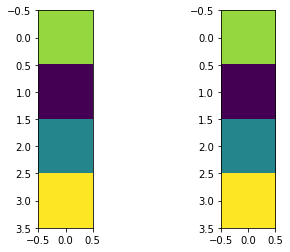

In [40]:
plt.figure()

plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)